
### Simulating a Zombie pandemic in an urban setting 


Any transportation network can be represented as a complex directed graph where vertices are spread an Euclidean space. The library provides a bridging functionality between real world spatial data available in the OpenStreetMap project and Graphs.jl and makes it possible to run real-life-sized experiment on transportation networks along with various visualizations.



Firstly, let us start by installing the required Julia and Python packages. (If the packages are required uncomment the code below)

In [61]:
using Random
using Parameters
using OpenStreetMapX
using Plots
ENV["GKSwstype"]="nul"
gr()
using OpenStreetMapXPlot
using Graphs
using Colors


In [62]:
pwd()  # use this to to check in which folder you are, the folder should contain the torontoF.osm file

"C:\\AAABIBLIOTEKA\\Salerno\\2024_Julia_Salerno\\6_Simulation_Models"

We start by loading the file. Note that we trim the map file to have a fully connected road network.

> The file was downloaded from the [OpenStreetMap](https://www.openstreetmap.org/) project web page. The steps included: (1) Select some area on map; (2) Click the "Export" button at the top of the page; (3) Click "Manually select a different area" to select the central Toronto area; (4) Press the "Export" button on the left (note that sometimes the Export link does not work - in this case click one of the Overpass API link below the Export button).



In [63]:
m = get_map_data("mokotow.osm", use_cache=false, trim_to_connected_graph=true );

The central element of the `MapData` object is a `Graphs.jl`' representation of the road network

In [64]:
m.g

{130, 216} directed simple Int64 graph

The Graphs.jl graph is represented by nodes, each node id can be directly mapped to OpenStreetMap. 

In [65]:
m.n

130-element Vector{Int64}:
            31718227
            32126048
            32126047
            31884830
            31718307
            31884821
          2511487062
            26118477
          2684219695
            32600277
            31906466
          2684219696
            31884832
                   ⋮
           254173054
 6421413477072123768
          4983636320
          4983638821
          4672231881
          4983638824
          5019379133
          5019388794
          5019379136
          5026362264
            32024600
          1317133131

Furhther, those nodes can be presented as geographic coordinates

In [66]:
m.nodes

Dict{Int64, ENU} with 571 entries:
  43283780             => ENU(-165.036, -558.59, -0.0266017)
  2684219696           => ENU(-115.456, -435.492, -0.0159167)
  38432721             => ENU(504.943, -608.962, -0.0490292)
  2768605666           => ENU(-127.631, -450.069, -0.0171606)
  4398297042           => ENU(637.367, -525.137, -0.0534071)
  31897859             => ENU(647.805, -565.939, -0.0579478)
  2405949488           => ENU(257.758, 737.202, -0.0478198)
  33312074             => ENU(64.5577, -733.845, -0.042561)
  1317127876           => ENU(505.369, -293.708, -0.0267449)
  1437918399           => ENU(-198.005, 703.907, -0.0419263)
  3890758954           => ENU(-869.338, 10.0017, -0.0591291)
  4983691482           => ENU(233.846, -32.419, -0.00436028)
  254167484            => ENU(386.592, 266.332, -0.0172545)
  30901479             => ENU(-874.312, 677.965, -0.0958475)
  26118477             => ENU(-59.287, -757.234, -0.0452451)
  4983636316           => ENU(58.617, -178.445, -0.

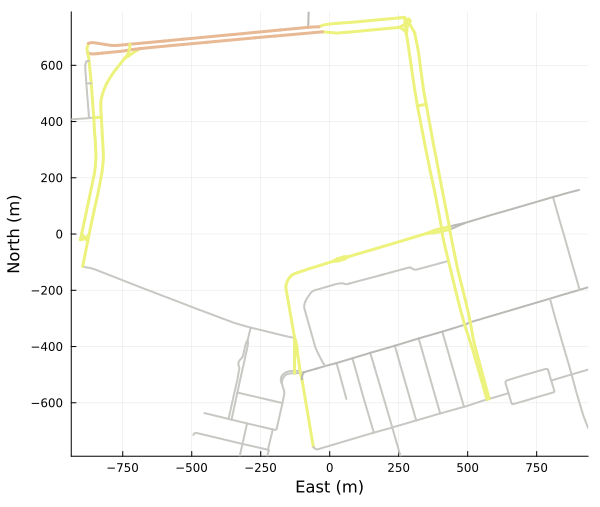

In [67]:
plotmap(m)

Let's take 10 zombies an let them walk between randomly selected pairs of points

In [68]:
a = m.n[5]
b = m.n[9]
shortest_route(m, a, b)


([31718307, 32024535, 26118477, 2684219695], 469.91664152023, 35.721131248130284)

In [69]:
typeof(m.g)

SimpleDiGraph{Int64}

Let now us try to built a simple simulation model of a pandemic in the city.

We start by a data structure defining location of an agent traversing the graph:

In [70]:
m.g

{130, 216} directed simple Int64 graph

In [71]:
struct OSMXPos
    node1::Int # starting node
    node2::Int # target node (if it is equal to node1 the agent 
               # makes decision on the next step)
    trav::Float64 #travelled %
end



In [72]:
# helper constructors for representation of movement
OSMXPos(node1::Int, node2::Int) = OSMXPos(node1, node2, 0.0) #agent decided to head to node 2
OSMXPos(node::Int) = OSMXPos(node, node) # agent arrived to node
function OSMXPos(pos::OSMXPos, delta::Float64)
    trav = pos.trav + delta
    trav >= 1.0 && return OSMXPos(pos.node2)
    trav <= 0.0 && return OSMXPos(pos.node1)
    return OSMXPos(pos.node1, pos.node2, trav)
end

OSMXPos

We move to a definition of an `Agent`

In [73]:
@with_kw mutable struct Agent
    id::Int    
    pos::OSMXPos
    infected::Bool = false
    #travel plan
    path::Dict{Int,Int} = Dict{Int,Int}() #seqence of nodes  1=>2,  2=>7, 7 => 12
    path_distances::Dict{Int,Float64} = Dict{Int,Float64}() # 100m    400m  500m
    # distance from each node in the sequence    
end
Agent(id,pos)=Agent(id=id,pos=pos)

Agent

Once the agent is defined let us define the enviroment where they can move around.

In [74]:
@with_kw struct Simulation
    agents::Vector{Agent} 
    m::MapData
    nodes_agents::Vector{Set{Int}}
    infected_agents_count::Vector{Int}
end

# constructor
# simulation initializer
function Simulation(m::MapData, N=150)    
    vv = nv(m.g) # number of vertices
    agents = Agent.(1:N, OSMXPos.(rand(1:vv,N)))
    
    nodes_agents = [Set{Int}() for _ in 1:vv]
    for agent in agents
        push!(nodes_agents[agent.pos.node1], agent.id)
    end
    
    patient_zero = rand(agents)
    patient_zero.infected = true
     
    Simulation(agents=agents, m=m, 
        nodes_agents=nodes_agents, infected_agents_count=[1])
end

Simulation

In [75]:
s = Simulation(m)


Simulation
  agents: Array{Agent}((150,))
  m: MapData
  nodes_agents: Array{Set{Int64}}((130,))
  infected_agents_count: Array{Int64}((1,)) [1]


Now we define the plotting function:

In [76]:
# helper functions for location processing
function get_ENU(node::Int, model)
    model.m.nodes[m.n[node]]
end

function get_coordinates(agent, model)
    pos1 = get_ENU(agent.pos.node1, model)
    pos2 = get_ENU(agent.pos.node2, model)
    (getX(pos1)*(1-agent.pos.trav)+getX(pos2)*(agent.pos.trav),
     getY(pos1)*(1-agent.pos.trav)+getY(pos2)*(agent.pos.trav))
end

# helper functions for colors
agentcolor(agent) = agent.infected ? :green : :black
agentsize(agent) = agent.infected ? 10 : 5

# actual plotting function
function plot_simstate(model, background=Plots.current())    
    for agent in model.agents
        path = [agent.pos.node1]
        while path[end] in keys(agent.path)
            push!(path, agent.path[path[end]])
        end
        length(path) < 2 && continue
        a_x, a_y = get_coordinates(agent, model)
        enu_coords = get_ENU.(path[2:end], Ref(model))

        a_x2, a_y2 = (getX(enu_coords[1]), getY(enu_coords[1]))
        
        !(a_x == a_x2 && a_y == a_y2) &&  plot!(
                background, [a_x, a_x2], [a_y, a_y2], 
                color=agentcolor(agent), arrow =arrow(:open))

        length(enu_coords) > 2 &&  plot!(
                background, getX.(enu_coords),  getY.(enu_coords),
                color=agentcolor(agent), arrow =arrow(:closed))
    end
    colors = [agentcolor(agent) for agent in model.agents]
    sizes = [agentsize(agent) for agent in model.agents]
    markers = :circle
    pos = [get_coordinates(agent, model) for agent in model.agents]
    scatter!(background,
        pos;
        markercolor = colors,
        markersize = sizes,
        markershapes = markers,
        label = "",
        markerstrokewidth = 0.5,
        markerstrokecolor = :black,
        markeralpha = 0.7,
    )
    
end

plot_simstate (generic function with 2 methods)

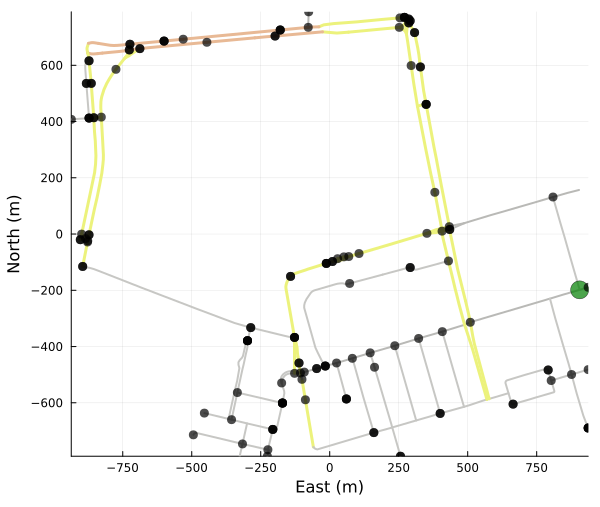

In [77]:
s=Simulation(m)
plotmap(s.m)
plot_simstate(s)

Now we need to define how the agents move around

In [78]:
function move_agent!(agent, model; meters=50.0)  
    if agent.pos.node1 == agent.pos.node2
        #selecting new travel destination if none exists
        if ! (agent.pos.node1 in keys(agent.path))            
            nodes = Int[]
            while length(nodes) < 2
                n2 = rand(1:nv(model.m.g))
                nodes =  getindex.(Ref(model.m.v), 
                        shortest_route(model.m,model.m.n[agent.pos.node1],
                                       model.m.n[n2])[1])
            end
            empty!(agent.path)
            setindex!.(Ref(agent.path), nodes[2:end], nodes[1:end-1])
            for i in 1:(length(nodes)-1)
                agent.path_distances[nodes[i]] = model.m.w[nodes[i], nodes[i+1]]
            end
        end     
        node2 = agent.path[agent.pos.node1]        
        trav = meters/agent.path_distances[agent.pos.node1]
        if trav >= 1.0
            pos = OSMXPos(node2)
        else
            pos = OSMXPos(agent.pos.node1, node2, trav)
        end        
    else
        pos = OSMXPos(agent.pos, meters/agent.path_distances[agent.pos.node1])
    end 
    if pos.node1 !== agent.pos.node1
        delete!(model.nodes_agents[agent.pos.node1], agent.id)
        push!(model.nodes_agents[pos.node1], agent.id)
    end
    agent.pos = pos
end


move_agent! (generic function with 1 method)

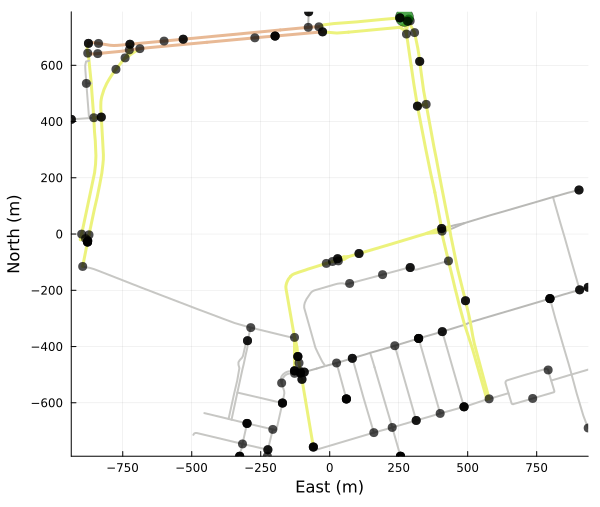

In [79]:
s=Simulation(m)
plotmap(s.m)
plot_simstate(s)

Having moevment function defined we can define the step function.

In [80]:
function step!(model) 
    new_infections = 0
    for agent in model.agents
        move_agent!(agent, model; meters=50.0) 
        if agent.infected
            for i in model.nodes_agents[agent.pos.node2]            
                model.agents[i].infected && continue
                if agent.pos.node1 == agent.pos.node2 
                    model.agents[i].infected = (model.agents[i].pos.node2 == agent.pos.node1)
                else
                    model.agents[i].infected = (model.agents[i].pos.node2 == agent.pos.node1)
                end
                new_infections += model.agents[i].infected
            end
        else
            for i in model.nodes_agents[agent.pos.node2]            
                (! model.agents[i].infected) && continue
                if agent.pos.node1 == agent.pos.node2 
                    agent.infected = model.agents[i].pos.node2 == agent.pos.node1
                else
                    agent.infected = model.agents[i].pos.node2 == agent.pos.node1
                end              
            end
            new_infections += agent.infected
        end
    end
    push!(model.infected_agents_count, model.infected_agents_count[end]+new_infections)
end

step! (generic function with 1 method)

We run the simulation for 10000 steps and watch the pandemic to develop

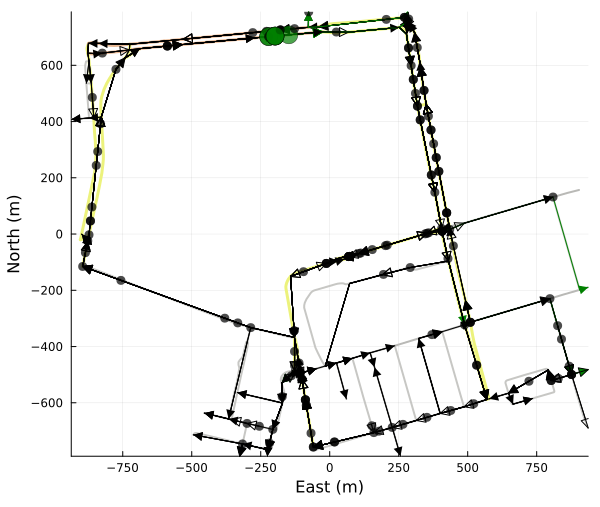

In [81]:
overl = plotmap(s.m) # overlay map to speed up plotting
Random.seed!(1)
s = Simulation(m)
for i in 1:30
    step!(s)
end

plot_simstate(s, deepcopy(overl))

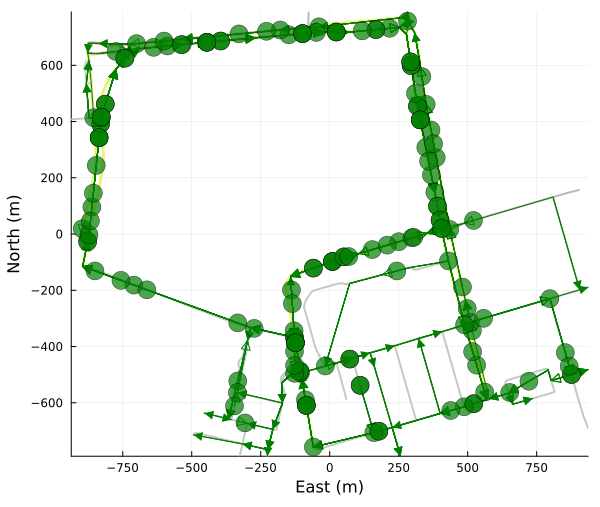

In [82]:
for i in 1:300
    step!(s)
end

plot_simstate(s, deepcopy(overl))

In [83]:
Random.seed!(1)
s = Simulation(m, 50)
p = plotmap(s.m)


frames = Plots.@animate for i in 1:100
    i > 1 && step!(s)
    plot_simstate(s, deepcopy(p))
end

gif(frames, "anim.gif", fps = 4);

[ Info: Saved animation to C:\AAABIBLIOTEKA\Salerno\2024_Julia_Salerno\6_Simulation_Models\anim.gif


In [84]:
using Plots
Random.seed!(1)
function randres(N=200,steps=100)
    s = Simulation(m,N)
    for i in 1:steps
        step!(s)
    end
    s.infected_agents_count ./ N
end
res_total = hcat((randres(200,100) for i in 1:200)...);
res_total

101×200 Matrix{Float64}:
 0.005  0.005  0.005  0.005  0.005  …  0.005  0.005  0.005  0.005  0.005
 0.005  0.005  0.005  0.01   0.055     0.02   0.03   0.015  0.035  0.01
 0.005  0.015  0.005  0.01   0.065     0.02   0.05   0.025  0.05   0.01
 0.02   0.015  0.015  0.02   0.095     0.02   0.085  0.075  0.05   0.01
 0.02   0.015  0.025  0.02   0.105     0.02   0.085  0.075  0.05   0.01
 0.02   0.015  0.035  0.025  0.11   …  0.02   0.085  0.075  0.06   0.01
 0.035  0.015  0.045  0.03   0.135     0.02   0.085  0.075  0.065  0.01
 0.04   0.015  0.055  0.03   0.165     0.02   0.11   0.075  0.065  0.01
 0.045  0.015  0.065  0.05   0.18      0.02   0.13   0.075  0.065  0.01
 0.065  0.02   0.09   0.08   0.205     0.02   0.135  0.075  0.065  0.01
 0.075  0.035  0.1    0.085  0.23   …  0.02   0.14   0.075  0.065  0.01
 0.075  0.055  0.115  0.105  0.235     0.02   0.145  0.075  0.065  0.01
 0.085  0.065  0.125  0.18   0.285     0.02   0.15   0.08   0.065  0.01
 ⋮                                  ⋱ 

In [85]:
using Statistics

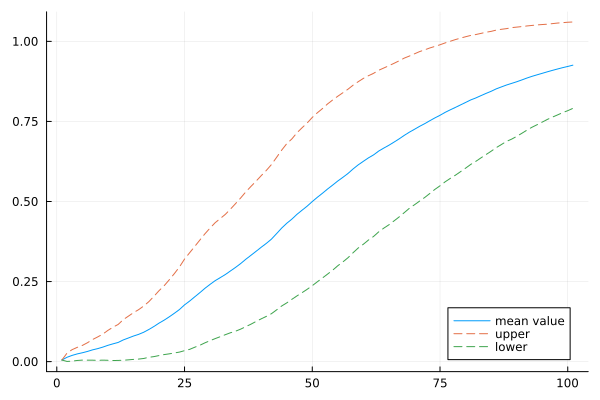

In [86]:
mvs = mean(res_total,dims=2)
plot(mvs, legend=:bottomright, lab="mean value")
plot!(mvs.+std(res_total,dims=2), linestyle=:dash, lab="upper")
plot!(mvs.-std(res_total,dims=2), linestyle=:dash, lab="lower")


In [87]:
#takes very long time (around 1mins) to compute!
res100 = hcat((randres(100,100) for i in 1:20)...);
res200 = hcat((randres(200,100) for i in 1:20)...);
res500 = hcat((randres(500,100) for i in 1:20)...);
res1000 = hcat((randres(1000,100) for i in 1:20)...);

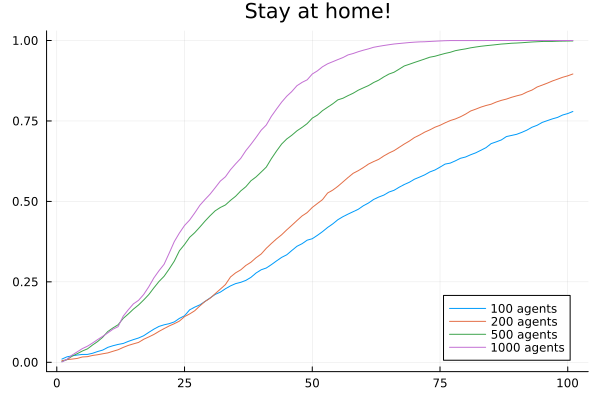

In [88]:
plot(mean(res100,dims=2), legend=:bottomright, lab="100 agents")
plot!(mean(res200,dims=2), lab="200 agents")
plot!(mean(res500,dims=2), lab="500 agents")
plot!(mean(res1000,dims=2), lab="1000 agents")
title!("Stay at home!")